In [1]:
from symmer.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, 
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symmer.symplectic import *
from symmer.utils import exact_gs_energy
from symmer.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symmer.chem import geometry_from_pubchem, MoleculeBuilder
from matplotlib import pyplot as plt
from functools import reduce
import json

In [3]:
with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('../data/score_data.json', 'r') as infile:
    scoring_data = json.load(infile)

molecules = [speciesname for speciesname in molecule_geometries.keys() 
             if (speciesname in scoring_data and
                 scoring_data[speciesname]['n_qubits_pre_taper']<100# and
                 #speciesname.find('+')==-1 and
                 #speciesname.find('-')==-1 and
                 #speciesname.find('SINGLET')!=-1
                )
            ]
print(molecules)

['H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CH3OCH3_STO-3G_SINGLET', 'C2H5F_STO-3G_SINGLET', 'CH3COCH3_STO-3G_SINGLET', 'N2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET']


In [4]:
def build_mol(speciesname, fci=True):
    #print(speciesname in scoring_data)
    mol_data = molecule_geometries[speciesname]
    if 'name' in mol_data:
        print(mol_data['name'])

    atoms  = mol_data['atoms']
    coords = mol_data['coords']
    basis  = mol_data['basis'] #'6-31g' #'cc-pVDZ' #
    spin   = mol_data['multiplicity']
    charge = mol_data['charge']
    geometry = list(zip(atoms, coords))
    molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, run_fci=fci)
    return molecule

# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
molecule = build_mol(speciesname)

Molecule geometry:
O	0	0	0
H	0.952519	0	0
H	-0.246530058	0.9200627021	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -74.96203967838721
MP2 energy:  -74.99708201366197
CCSD energy: -75.01073164269071
FCI energy:  -75.01084664816946


Number of qubits: 14


In [5]:
def taper_ham(molecule):
    taper_hamiltonian = QubitTapering(molecule.H_q)

    print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
    print('The symmetry generators are\n')
    print(taper_hamiltonian.symmetry_generators)
    print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
    print(taper_hamiltonian.stabilizers.stabilizer_rotations)
    print('\nonto the single-qubit Pauli operators\n')
    print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
    hf_array = molecule.H_fermion.hf_comp_basis_state
    taper_hamiltonian.stabilizers.update_sector(hf_array)
    print(f'\nThe symetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')
    ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
    #sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
    #sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
    ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
    n_taper = taper_hamiltonian.n_taper
    tapered_qubits   = taper_hamiltonian.stab_qubit_indices
    untapered_qubits = taper_hamiltonian.free_qubit_indices
    hf_tapered = taper_hamiltonian.tapered_ref_state
    print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
    return ham_tap, ucc_tap, hf_tapered

ham_tap, ucc_tap, hf_tapered = taper_ham(molecule)

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIIZZIIZZIIZ 
 1 IZIZIZIZIZIZIZ 
 1 IIIIZZIIIIIIZZ 
 1 IIIIIIIIZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

None

onto the single-qubit Pauli operators

-1 IIIIIIIIXIIIII 
-1 IIIIXIIIIIIIII 
-1 IXIIIIIIIIIIII 
-1 XIIIIIIIIIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0] is [-1 -1  1  1]
The tapered Hartree-Fock state is  1.0000000000 |1111110000>


In [7]:
from symmer.projection import CS_VQE, CS_VQE_LW

cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
cs_vqe_2 = CS_VQE(ham_tap, hf_tapered, noncontextual_form='diag')

In [8]:
max_sim_q = 14
def score_CC_generated_stabilizers(max_sim_q=max_sim_q):
    scores = []

    for i in range(1, ham_tap.n_qubits):
        CC_stabilizers = StabilizerIdentification(ucc_tap)
        S_CC           = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
        stab_score_CC  = cs_vqe.basis_score(S_CC)
        if i <= max_sim_q:
            ham_cs = cs_vqe.project_onto_subspace(S_CC)
            matrix = ham_cs.to_sparse_matrix
            cs_energy = exact_gs_energy(matrix)[0]
            error = cs_energy-molecule.fci_energy
            print(f'{i}-qubit CS-VQE error w.r.t. CCSD is {error:.5f} with stabilizer score {stab_score_CC:.5f}')
        else:
            cs_energy = None
            print(f'{i}-qubit CS-VQE energy not computed - stabilizer score {stab_score_CC:.5f}')

        scores.append((stab_score_CC, cs_energy))
        
    return scores

scores = score_CC_generated_stabilizers()

1-qubit CS-VQE error w.r.t. CCSD is 0.03641 with stabilizer score 0.10762
2-qubit CS-VQE error w.r.t. CCSD is 0.03242 with stabilizer score 0.18922
3-qubit CS-VQE error w.r.t. CCSD is 0.02581 with stabilizer score 0.33421
4-qubit CS-VQE error w.r.t. CCSD is 0.01753 with stabilizer score 0.54761
5-qubit CS-VQE error w.r.t. CCSD is 0.01122 with stabilizer score 0.68639
6-qubit CS-VQE error w.r.t. CCSD is 0.00145 with stabilizer score 0.89338
7-qubit CS-VQE error w.r.t. CCSD is 0.00041 with stabilizer score 0.94456
8-qubit CS-VQE error w.r.t. CCSD is 0.00008 with stabilizer score 0.99105
9-qubit CS-VQE error w.r.t. CCSD is 0.00005 with stabilizer score 0.99477


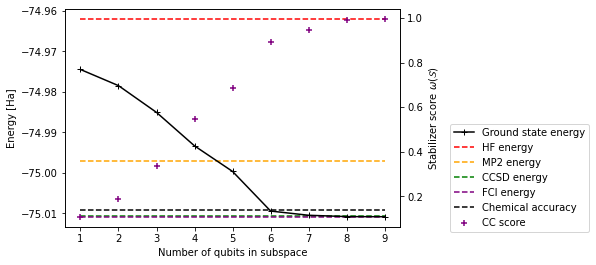

In [9]:
fig,energy_axis = plt.subplots()
X = np.arange(1, ham_tap.n_qubits)
Y_score,Y_energy = zip(*scores)

energy_axis.plot(X[:max_sim_q], Y_energy[:max_sim_q], color='black', marker='+', label='Ground state energy')
energy_axis.hlines(molecule.hf_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
if molecule.fci_energy is not None:
    energy_axis.hlines(molecule.fci_energy, 1, X[-1], ls='--', color='purple', label='FCI energy')
    energy_axis.hlines(molecule.fci_energy+0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_yscale('log')
energy_axis.set_ylabel('Energy [Ha]')
energy_axis.set_xlabel('Number of qubits in subspace')

score_axis = energy_axis.twinx()
score_axis.scatter(X, Y_score, color='purple', label='CC score', marker='+')

score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
plt.show()

In [10]:
from symmer.utils import random_symplectic_matrix

In [11]:
results_out={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(n_stabs)
    n_samples = 0
    data = []
    while n_samples<=100:
        print(n_samples)
        try:
            S = StabilizerOp(random_symplectic_matrix(ham_tap.n_qubits, n_stabs, diagonal=True), np.ones(n_stabs))
            stab_score_cc = cs_vqe.basis_score(S)
            stab_score_ham = cs_vqe_2.basis_score(S)
            ham_cs = cs_vqe.project_onto_subspace(S)
            matrix = ham_cs.to_sparse_matrix
            cs_energy = exact_gs_energy(matrix)[0]
            data.append([stab_score_ham, stab_score_cc, cs_energy])
            n_samples+=1
        except:
            pass
    results_out[ham_tap.n_qubits - n_stabs] = data
    print()

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
85
86
87
88
89
90
91
91
92
93
94
95
96
97
98
99
100

3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


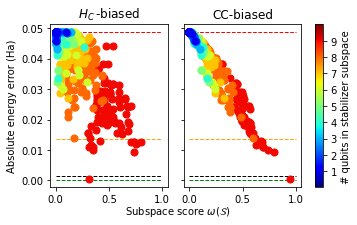

In [15]:
from matplotlib.pyplot import Normalize

fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5,3),
                           gridspec_kw={'width_ratios': [10, 10, 1]})
        
#data = randomized[speciesname]
n_qubits = ham_tap.n_qubits
n_qubits_full = molecule.n_qubits
hf_energy = molecule.hf_energy
mp2_energy = molecule.mp2_energy
ccsd_energy = molecule.ccsd_energy
fci_energy = molecule.fci_energy
ham_ucc_nrg = results_out
increments=[]

for n_sim_qubits,results in ham_ucc_nrg.items():
    ratio = int(n_sim_qubits)/n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, X_nrg = zip(*results)
    X_ham = np.array(X_ham)
    X_ucc = np.array(X_ucc)
    Y_nrg = np.array(X_nrg) - fci_energy

    axes[0].scatter(X_ham,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
    axes[1].scatter(X_ucc,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)

def plot_lines(axis):
    axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
    axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
    axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
    axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')
plot_lines(axes[0])
plot_lines(axes[1])

keys = list(ham_ucc_nrg.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axes[2], label='# qubits in stabilizer subspace', ticks=increments, fraction=1.2)
cbar.ax.set_yticklabels(keys)

axes[0].set_title('$H_{C}\,$-biased')
axes[1].set_title('CC-biased')
axes[0].set_ylabel('Absolute energy error (Ha)')
axes[1].set_xlabel('Subspace score $\omega(\mathcal{S})$')
axes[1].xaxis.set_label_coords(-0.05,-0.1)
axes[2].set_visible(False)    

filename = f'plots/{speciesname}_score_vs_energy.png'

In [26]:
results_out

{}